# Trabajo práctico 1

## Autor: Collado Claudio

*El objetivo del trabajo práctico es trabajar con los conceptos de aprendizaje por gradiente, perceptrones multi-capas y reducción de overfitting. Para esto trabajaremos con un conjunto de similar al MNIST, pero con lenguaje de señas en vez de caracteres. El dataset está publicado originalmente en https://www.kaggle.com/datamunge/sign-language-mnist, pero se provee una versión preprocesada ya cargada en arreglos numpy. Las características de dataset son:*

| Propiedad | Valor |
| --- | --- |
| Clases | 25 |
| Tamaño de las imagenes | 28 X 28 X 1 |
| Instancias de entrenemiento | 27.455 |
| Instancias de validación | 7.172 |
| Valor mínimo de cada pixel | 0 |
| Valor máximo de cada pixel | 255 |

In [1]:
#Importo los modulos a utilizar

import urllib.request
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import random
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GaussianNoise, GaussianDropout, LayerNormalization
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.datasets import mnist 
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
tf.random.set_seed(1234)

File does not exist
...100%, 25 MB, 2424 KB/s, 10 seconds passed100 primeros elementos del conjunto de entrenaimento


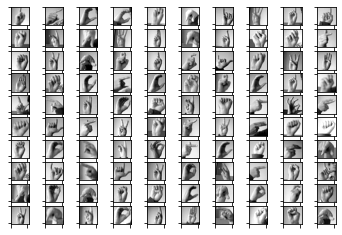

[ 3  6  2  2 13 16  8 22  3  3 18 10 16 22 20 16 17 13 13 19 18 21 16 23
  3 23 24 18 22  1  1 12  2  6  2 12 23  2  3 13 11 15 20  2  4 10  0 19
  5  7  0 11  6 21 18 19 21  7  0  0  4 14 15 10  5 19  2 13  7 16 12  8
 15 11 21 14 10  6 18 11 16 14 16 18  4  2 16 14 23  0 21 16 10 14 17  1
 15 18  4 16]


In [2]:
#Cargando datos
def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

# como vamos a necesitar descargar más archivos posteriormente, definimos una función que lo haga

def descargar_archivo(url,datapath):
    if not os.path.exists(datapath): # antes de descargar el archivo controlamos que no exista
       print("File does not exist")
  
       print("Downloading file...") 
       urllib.request.urlretrieve(url, datapath, reporthook)
        

descargar_archivo('https://users.exa.unicen.edu.ar/~jmrodri/sign_imgs.npz', 'sign_imgs.npz')
data = np.load('sign_imgs.npz', allow_pickle=True)
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']
print('100 primeros elementos del conjunto de entrenaimento')
f = plt.figure(111)
for i in range(10):
    for j in range(10):
        ax = f.add_subplot(10, 10, i + j*10 + 1)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        ax.imshow(x_train[i + j*10, :, :, 0], cmap='gray')
plt.show()
print(y_train[:100])

## 1. Ejercicio N°1

*Implemente un modelo con softmax y una capa para predecir las señas. Implemente todo el algoritmo de aprendizaje, sin usar keras, utilizando Stochastic Gradient Descent. Evalue diversos parámetros para el lr y momentum.*

In [3]:
# Defino el tamaño de los vectores de entrada
# Escalo los valores numericos de pixeles a [0-1]
# Paso a categorico el target

size = x_train.shape[1]*x_train.shape[2]
x_train = x_train.reshape((x_train.shape[0], size)) / 255
x_test = x_test.reshape((x_test.shape[0], size)) / 255

yc_train, yc_test = to_categorical(y_train), to_categorical(y_test)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
yc_train = yc_train.astype(np.float32)
yc_test = yc_test.astype(np.float32)

In [4]:
#Funcion softmax
def softmax(z):
    exp = tf.exp(z)
    return exp / tf.expand_dims(tf.math.reduce_sum(exp, axis=1), axis=-1)

#Funcion para realizar la prediccion
def predict(x, w, b):
    return softmax(tf.matmul(x, w) + b)

# Funcion entropia cruzada
def categorical_crossentropy(y_true, y_pred):
    return tf.math.reduce_mean(-tf.math.reduce_sum(y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-6, 1)), axis=1))

#Funcion de perdida
def loss_f(y_true, x, w, b):
    return categorical_crossentropy(y_true, predict(x, w, b))

#Funcion que implementa Stochastic Gradient Descent
def SGD(lr_sgd,momentum_sgd,batch_size_sgd,ciclos_sgd,n_clases):
  w = tf.random.uniform(shape=[size, n_clases], minval=-1, maxval=1)
  b = tf.random.uniform(shape=[n_clases], minval=-1, maxval=1)
  ciclos = ciclos_sgd
  lr = lr_sgd 
  momentum = momentum_sgd
  mini_batch_size = batch_size_sgd
  errors = []
  errors_minibatch = []
  vw = tf.zeros(shape=[size, 25])
  vb = tf.zeros(shape=[25])
  for i in tqdm(range(ciclos)):
      x_s, y_s = shuffle(x_train, yc_train)
      for mini_batch in range(0, x_s.shape[0], mini_batch_size):
          with tf.GradientTape() as g:
              g.watch([w, b])
              loss = loss_f(y_s[mini_batch:mini_batch+mini_batch_size], x_s[mini_batch:mini_batch+mini_batch_size], w, b)
              errors_minibatch.append(loss.numpy())
          gw, gb = g.gradient(loss, [w, b])
          vw = momentum * vw - lr * gw
          vb = momentum * vb - lr * gb
          w = w + vw
          b = b + vb
      errors.append(loss_f(yc_train, x_train, w, b).numpy())
      
  return errors,errors_minibatch,w,b

### 1.1 Modelos - Diferentes valores de Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

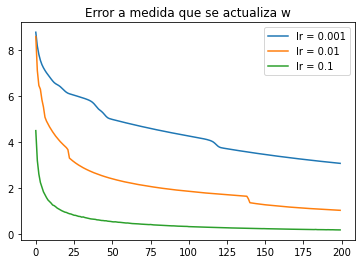

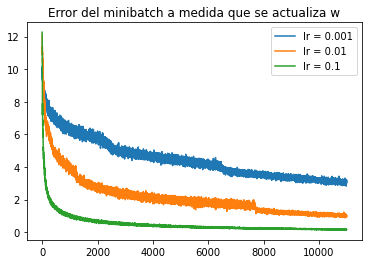

In [5]:
#3 modelos con diferente valor de learning rate
a = SGD(0.001,0.5,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)
b = SGD(0.01,0.5,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)
c = SGD(0.1,0.5,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)

#Plot de los errores 
plt.plot(a[0],label='lr = 0.001')
plt.plot(b[0],label='lr = 0.01')
plt.plot(c[0],label='lr = 0.1')
plt.title('Error a medida que se actualiza w')
plt.legend()
plt.show()

#Plot de los errores del minibatch
plt.plot(a[1],label='lr = 0.001')
plt.plot(b[1],label='lr = 0.01')
plt.plot(c[1],label='lr = 0.1')
plt.title('Error del minibatch a medida que se actualiza w')
plt.legend()
plt.show()

Observaciones:

*   Como era de esperar a medida que crece la cantidad de ciclos el comportamiento de los errores es monotamente decreciente
*   Se observa que a una cantidad fija de ciclos el modelo con menor valor de 
learning rate tiene valores de errores superior a aquellos modelos con learning rate mayor: Esto se nota marcadamente para lr=0.001
*   El comportamiento de los errores para learning rate 0.01 y 0.1 son similares

### 1.2 Modelos - Diferentes valores de Momentum

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

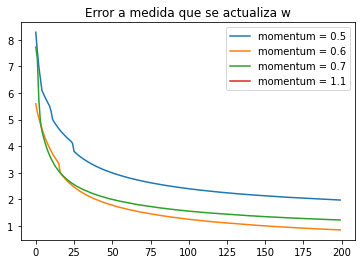

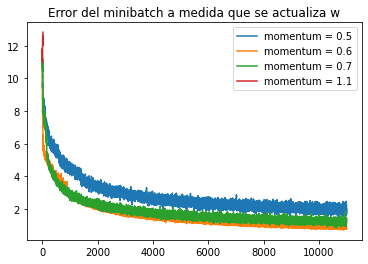

In [6]:
a = SGD(0.01,0.5,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)
b = SGD(0.01,0.6,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)
c = SGD(0.01,0.7,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)
d = SGD(0.01,1.1,batch_size_sgd=500,ciclos_sgd=200,n_clases=25)

plt.plot(a[0],label= 'momentum = 0.5')
plt.plot(b[0],label='momentum = 0.6')
plt.plot(c[0],label='momentum = 0.7')
plt.plot(d[0],label='momentum = 1.1')
plt.title('Error a medida que se actualiza w')
plt.legend()
plt.show()

plt.plot(a[1],label= 'momentum = 0.5')
plt.plot(b[1],label='momentum = 0.6')
plt.plot(c[1],label='momentum = 0.7')
plt.plot(d[1],label='momentum = 1.1')
plt.title('Error del minibatch a medida que se actualiza w')
plt.legend()
plt.show()

Observaciones:

*   Como era de esperar a medida que crece la cantidad de ciclos el comportamiento de los errores es monotamente decreciente
*   Se observa que a una cantidad fija de ciclos el modelo con mayor valor de 
momentum tiene valores de errores superior a aquellos modelos con momentum menor: Esto se nota marcadamente para momentum=0.7
*   El comportamiento de los errores para momentum 0.6 y 0.7 son similares
*   Se incorporo un valor de momentum superior a 1 (valor no utilizado en la practica): En las curvas de error no se observa el comportamiento y en las curva de error del minibatch se observa solamente al inicio



### 1.3 Metrica para un modelo especifico

Considerando un modelo especifico observo los valores de las metricas sobre el conjunto de test

In [7]:
#Modelo, pesos y bias

sgd = SGD(0.001,0.7,batch_size_sgd=50,ciclos_sgd=200,n_clases=25)
w = sgd[2]
b = sgd[3]

  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
#Predicciones y metricas

y_pred = predict(x_test, w, b).numpy()
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       331
           1       0.86      0.74      0.80       432
           2       0.69      0.93      0.79       310
           3       0.71      0.76      0.74       245
           4       0.81      0.92      0.86       498
           5       0.49      0.70      0.58       247
           6       0.74      0.66      0.70       348
           7       0.88      0.70      0.78       436
           8       0.58      0.48      0.52       288
          10       0.53      0.37      0.43       331
          11       0.00      0.00      0.00       209
          12       0.49      0.49      0.49       394
          13       0.40      0.36      0.38       291
          14       0.86      0.55      0.67       246
          15       0.82      0.90      0.86       347
          16       0.48      0.87      0.62       164
          17       0.10      0.28      0.15       144
          18       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Se observa que para ciertas señas se obtienen buenos resultados (ej: target 1,4 y 7) mientras que para otros lo resultados no son buenos (ej: target 13,17 y 22)

### 1.4 Considere la matriz de pesos (w de 784, 25). Por cada columna de esta matriz, cambiele la forma *np.reshape* a matrices de 28 por 28 y grafíque la imagen. Piense sobre lo que ve, ¿tiene algun sentido?.

In [57]:
#Matriz de pesos

w

<tf.Tensor: shape=(784, 25), dtype=float32, numpy=
array([[ 0.102184  ,  0.13202626, -0.5018931 , ..., -0.5160911 ,
        -0.85490566, -0.075457  ],
       [ 0.9665345 ,  0.01474091,  0.28422937, ...,  0.57369906,
         0.99711037, -0.5731928 ],
       [ 0.9221694 ,  0.50264144,  0.18114957, ...,  0.7186624 ,
        -0.69881254, -0.92657876],
       ...,
       [-0.22474538, -0.13728294,  0.0815826 , ...,  0.09560005,
        -0.8914625 , -0.05814631],
       [ 0.30071434,  0.50191987,  1.0356807 , ..., -0.44749257,
        -0.6337658 , -0.49202567],
       [-0.7860097 , -1.0123188 ,  0.70186406, ...,  0.39559206,
         0.64659387,  0.08606273]], dtype=float32)>

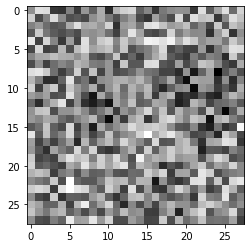

In [65]:
image0 = np.reshape(w[:,0],(28,28))
plt.imshow(image0, cmap='gray')

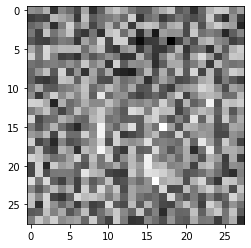

In [66]:
image1 = np.reshape(w[:,1],(28,28))
plt.imshow(image1, cmap='gray')

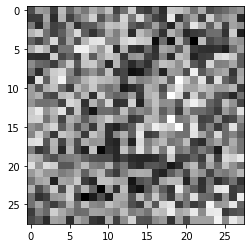

In [67]:
image2 = np.reshape(w[:,2],(28,28))
plt.imshow(image2, cmap='gray')

A lo que observo como resultado de las imagenes no lo encuentro sentido.

## 2. Ejercicio N°2

*Implemente un preceptron multi-capas para realizar las predicciones. Varie la cantidad de capas y parámetros para ver la relación entre error de training y test. Grafíquelos.*

Modelo N°1



In [10]:
#Definicion del modelo

i1 = Input((x_train.shape[1],))
d1 = Dense(64, activation='relu')(i1) #Capa oculta de 64 neuronas
d1 = Dense(25, activation='softmax')(d1) #Softmax como activacion final
model1 = Model(i1, d1)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 51,865
Trainable params: 51,865
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Entrenamiento del modelo

history1 = model1.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Epoch 1/20
858/858 [==============================] - 2s 2ms/step - loss: 2.6550 - accuracy: 0.2169 - val_loss: 2.2380 - val_accuracy: 0.3074
Epoch 2/20
858/858 [==============================] - 2s 2ms/step - loss: 1.8695 - accuracy: 0.4274 - val_loss: 1.8597 - val_accuracy: 0.4216
Epoch 3/20
858/858 [==============================] - 2s 2ms/step - loss: 1.5696 - accuracy: 0.5080 - val_loss: 1.6366 - val_accuracy: 0.4796
Epoch 4/20
858/858 [==============================] - 2s 2ms/step - loss: 1.4223 - accuracy: 0.5446 - val_loss: 1.5714 - val_accuracy: 0.5074
Epoch 5/20
858/858 [==============================] - 2s 2ms/step - loss: 1.3182 - accuracy: 0.5746 - val_loss: 1.5051 - val_accuracy: 0.5139
Epoch 6/20
858/858 [==============================] - 2s 2ms/step - loss: 1.2384 - accuracy: 0.5979 - val_loss: 1.4796 - val_accuracy: 0.5418
Epoch 7/20
858/858 [==============================] - 2s 2ms/step - loss: 1.1702 - accuracy: 0.6189 - val_loss: 1.4939 - val_accuracy: 0.5155
Epoch 

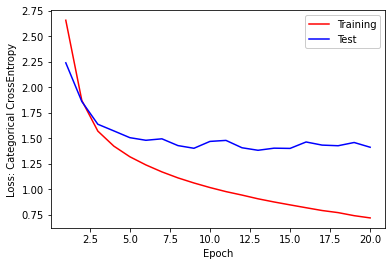

In [12]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history1.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history1.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

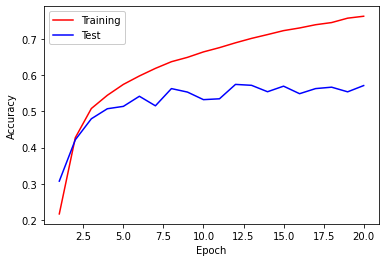

In [13]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history1.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history1.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo N°2

In [14]:
#Definicion del modelo

i2 = Input((x_train.shape[1],))
d2 = Dense(64, activation='relu')(i2) #Capa oculta de 64 neuronas
d2 = Dense(128, activation='relu')(d2) #Capa oculta de 128 neuronas
d2 = Dense(25, activation='softmax')(d2) #Softmax como activacion final
model2 = Model(i2, d2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                3225      
Total params: 61,785
Trainable params: 61,785
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Entrenamiento del modelo

history2 = model2.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Epoch 1/20
858/858 [==============================] - 2s 2ms/step - loss: 1.9949 - accuracy: 0.3785 - val_loss: 1.4908 - val_accuracy: 0.4941
Epoch 2/20
858/858 [==============================] - 2s 2ms/step - loss: 1.0385 - accuracy: 0.6630 - val_loss: 1.1635 - val_accuracy: 0.6171
Epoch 3/20
858/858 [==============================] - 2s 2ms/step - loss: 0.6804 - accuracy: 0.7823 - val_loss: 0.9967 - val_accuracy: 0.6854
Epoch 4/20
858/858 [==============================] - 2s 2ms/step - loss: 0.4879 - accuracy: 0.8447 - val_loss: 1.0771 - val_accuracy: 0.6736
Epoch 5/20
858/858 [==============================] - 2s 2ms/step - loss: 0.3600 - accuracy: 0.8848 - val_loss: 1.1803 - val_accuracy: 0.6468
Epoch 6/20
858/858 [==============================] - 2s 2ms/step - loss: 0.2629 - accuracy: 0.9212 - val_loss: 1.0699 - val_accuracy: 0.7078
Epoch 7/20
858/858 [==============================] - 2s 2ms/step - loss: 0.1916 - accuracy: 0.9439 - val_loss: 1.0467 - val_accuracy: 0.7287
Epoch 

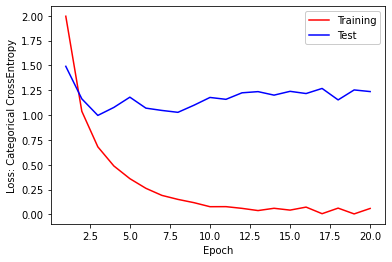

In [16]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history2.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history2.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

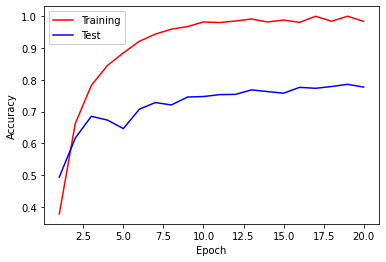

In [17]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history2.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history2.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo N°3

In [18]:
#Definicion del modelo

i3 = Input((x_train.shape[1],))
d3 = Dense(64, activation='relu')(i3) #Capa oculta de 64 neuronas
d3 = Dense(128, activation='relu')(d3) #Capa oculta de 128 neuronas
d3 = Dense(256, activation='relu')(d3) #Capa oculta de 256 neuronas
d3 = Dense(25, activation='softmax')(d3) #Softmax como activacion final
model3 = Model(i3, d3)
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                6425      
Total params: 98,009
Trainable params: 98,009
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Entrenamiento del modelo

history3 = model3.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Epoch 1/20
858/858 [==============================] - 3s 3ms/step - loss: 1.8820 - accuracy: 0.3865 - val_loss: 1.4624 - val_accuracy: 0.5144
Epoch 2/20
858/858 [==============================] - 2s 3ms/step - loss: 0.9151 - accuracy: 0.6862 - val_loss: 1.1896 - val_accuracy: 0.6057
Epoch 3/20
858/858 [==============================] - 2s 3ms/step - loss: 0.5058 - accuracy: 0.8293 - val_loss: 1.0475 - val_accuracy: 0.6788
Epoch 4/20
858/858 [==============================] - 2s 3ms/step - loss: 0.3098 - accuracy: 0.8975 - val_loss: 1.2111 - val_accuracy: 0.6967
Epoch 5/20
858/858 [==============================] - 2s 3ms/step - loss: 0.2006 - accuracy: 0.9353 - val_loss: 1.3570 - val_accuracy: 0.6369
Epoch 6/20
858/858 [==============================] - 2s 3ms/step - loss: 0.1709 - accuracy: 0.9446 - val_loss: 1.2886 - val_accuracy: 0.7119
Epoch 7/20
858/858 [==============================] - 2s 3ms/step - loss: 0.1089 - accuracy: 0.9648 - val_loss: 1.1651 - val_accuracy: 0.7359
Epoch 

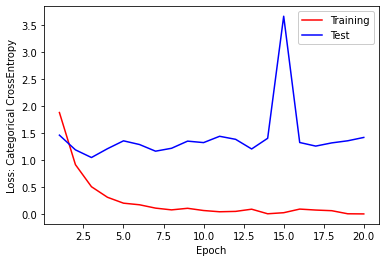

In [20]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history3.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history3.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

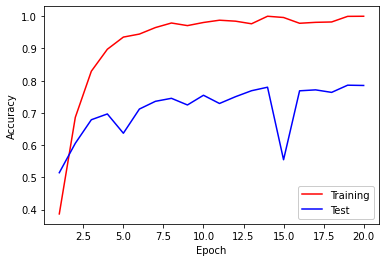

In [21]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history3.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history3.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Model N°4

In [22]:
#Definicion del modelo

i4 = Input((x_train.shape[1],))
d4 = Dense(512, activation='relu')(i4) #Capa oculta de 512 neuronas
d4 = Dense(256, activation='relu')(d4) #Capa oculta de 256 neuronas
d4 = Dense(128, activation='relu')(d4) #Capa oculta de 128 neuronas
d4 = Dense(25, activation='softmax')(d4) #Softmax como activacion final
model4 = Model(i4, d4)
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 25)                3225      
Total params: 569,369
Trainable params: 569,369
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Entrenamiento del modelo

history4 = model4.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Epoch 1/20
858/858 [==============================] - 6s 6ms/step - loss: 1.7960 - accuracy: 0.4178 - val_loss: 1.4621 - val_accuracy: 0.5301
Epoch 2/20
858/858 [==============================] - 5s 6ms/step - loss: 0.7583 - accuracy: 0.7383 - val_loss: 1.0557 - val_accuracy: 0.6786
Epoch 3/20
858/858 [==============================] - 5s 6ms/step - loss: 0.3786 - accuracy: 0.8718 - val_loss: 0.9006 - val_accuracy: 0.7326
Epoch 4/20
858/858 [==============================] - 5s 6ms/step - loss: 0.2191 - accuracy: 0.9263 - val_loss: 1.1558 - val_accuracy: 0.7253
Epoch 5/20
858/858 [==============================] - 5s 6ms/step - loss: 0.1490 - accuracy: 0.9497 - val_loss: 1.1404 - val_accuracy: 0.7326
Epoch 6/20
858/858 [==============================] - 5s 6ms/step - loss: 0.1078 - accuracy: 0.9646 - val_loss: 1.3064 - val_accuracy: 0.7255
Epoch 7/20
858/858 [==============================] - 5s 6ms/step - loss: 0.0839 - accuracy: 0.9725 - val_loss: 1.2619 - val_accuracy: 0.7815
Epoch 

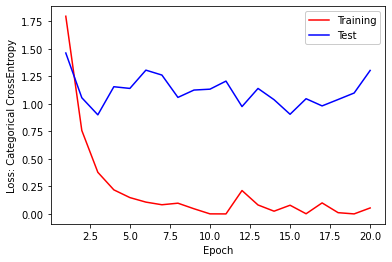

In [24]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history4.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history4.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

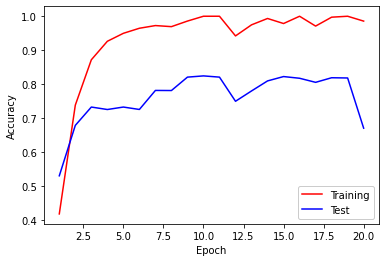

In [25]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history4.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history4.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Observaciones:



*   La incorporacion de otra capa en el Modelo N°2 mejora un poco el accuracy obtenido en test.
*   La incorporacion de otra capa en el Modelo N°3 no genera una mejora del accuracy en test, si no que este se comporta oscilante en valores similares a los Modelos N°1 y N°2
*   Para el cambio de arquitectura en el Modelo N°4 se observa una gran oscilacion en el comportamiento de la funcio de costo. Los valores de accuracy se observan superiores a los otros modelos, pero con un comportamiento muy oscilante
*   En todos los casos se observa que es posible reducir la cantidad de epochs  originalmente elegidas (20) 








## 3. Ejercicio 3

*Aplique técnicas de regularización sobre el problema. Compare las relacion entre los errores de training y test. Grafíquelos.*

### 3.1 Regularizacion L2

Modelo N°1

In [26]:
#Definicion del modelo
#Igual regularizacion para todas las capas ocultas

i5 = Input((x_train.shape[1],))
d5 = Dense(512, activation='relu', kernel_regularizer=L2(0.0001))(i5)
d5 = Dense(256, activation='relu', kernel_regularizer=L2(0.0001))(d5)
d5 = Dense(128, activation='relu', kernel_regularizer=L2(0.0001))(d5)
d5 = Dense(64, activation='relu', kernel_regularizer=L2(0.0001))(d5)
d5 = Dense(25, activation='softmax', kernel_regularizer=L2(0.0001))(d5)
model5 = Model(i5, d5)
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()
history5 = model5.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 25)                1625      
Total params: 576,025
Trainable params: 576,025
Non-trainable params: 0
_____________________________________________________

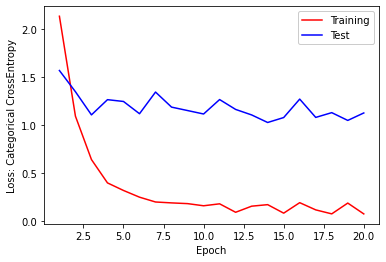

In [27]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history5.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history5.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

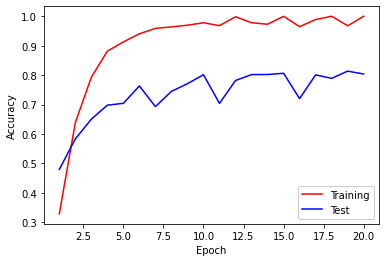

In [28]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history5.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history5.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo N°2

In [29]:
#Definicion del modelo
#Igual regularizacion para todas las capas ocultas

i6 = Input((x_train.shape[1],))
d6 = Dense(512, activation='relu', kernel_regularizer=L2(0.001))(i6)
d6 = Dense(256, activation='relu', kernel_regularizer=L2(0.001))(d6)
d6 = Dense(128, activation='relu', kernel_regularizer=L2(0.001))(d6)
d6 = Dense(64, activation='relu', kernel_regularizer=L2(0.001))(d6)
d6 = Dense(25, activation='softmax', kernel_regularizer=L2(0.001))(d6)
model6 = Model(i6, d6)
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model6.summary()
history6 = model6.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 25)                1625      
Total params: 576,025
Trainable params: 576,025
Non-trainable params: 0
_____________________________________________________

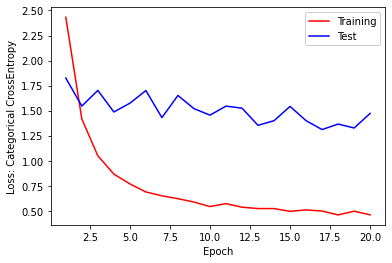

In [30]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history6.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history6.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

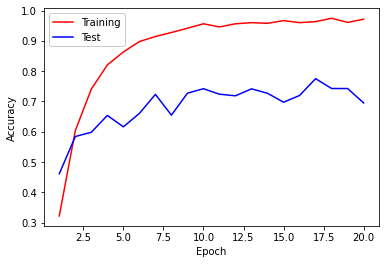

In [31]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history6.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history6.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo N°3

In [32]:
#Definicion del modelo
#Igual regularizacion para todas las capas ocultas

i7 = Input((x_train.shape[1],))
d7 = Dense(512, activation='relu', kernel_regularizer=L2(0.01))(i7)
d7 = Dense(256, activation='relu', kernel_regularizer=L2(0.01))(d7)
d7 = Dense(128, activation='relu', kernel_regularizer=L2(0.01))(d7)
d7 = Dense(64, activation='relu', kernel_regularizer=L2(0.01))(d7)
d7 = Dense(25, activation='softmax', kernel_regularizer=L2(0.01))(d7)
model7 = Model(i7, d7)
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model7.summary()
history7 = model7.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 25)                1625      
Total params: 576,025
Trainable params: 576,025
Non-trainable params: 0
_____________________________________________________

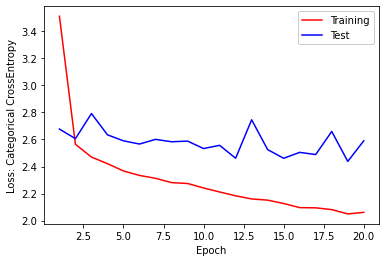

In [33]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history7.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history7.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

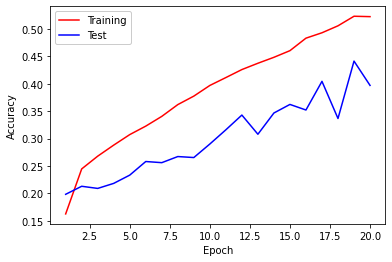

In [34]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history7.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history7.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Observaciones:

*   El aumento en el valor de regularizacion genera un aumento en la oscilacion de los valores de accuracy obtenidos en test
*  Nuevamente se observa que es posible reducir la cantidad de epochs  originalmente elegidas (20)



### 3.2 Regularizacion por Dropout

Modelo N°1

In [35]:
#Definicion del modelo
#Igual Dropout para todas las capas ocultas

i8 = Input((x_train.shape[1],))
d8 = Dense(512, activation='relu')(i8)
d8 = BatchNormalization()(d8)
d8 = Dropout(0.5)(d8)
d8 = Dense(256, activation='relu')(d8)
d8 = BatchNormalization()(d8)
d8 = Dropout(0.5)(d8)
d8 = Dense(128, activation='relu')(d8)
d8 = BatchNormalization()(d8)
d8 = Dropout(0.5)(d8)
d8 = Dense(25, activation='softmax')(d8)
model8 = Model(i8, d8)
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model8.summary()
history8 = model8.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

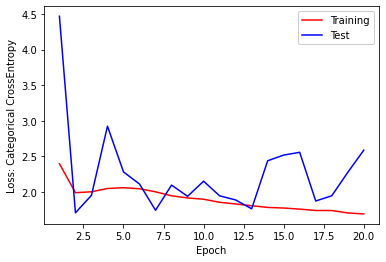

In [36]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history8.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history8.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

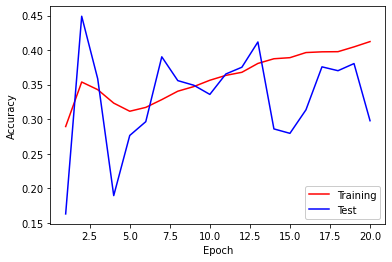

In [37]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history8.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history8.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo N°2

In [38]:
#Definicion del modelo
#Igual Dropout para todas las capas ocultas

i9 = Input((x_train.shape[1],))
d9 = Dense(512, activation='relu')(i9)
d9 = BatchNormalization()(d9)
d9 = Dropout(0.25)(d9)
d9 = Dense(256, activation='relu')(d9)
d9 = BatchNormalization()(d9)
d9 = Dropout(0.25)(d9)
d9 = Dense(128, activation='relu')(d9)
d9 = BatchNormalization()(d9)
d9 = Dropout(0.25)(d9)
d9 = Dense(25, activation='softmax')(d9)
model9 = Model(i9, d9)
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model9.summary()
history9 = model9.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0   

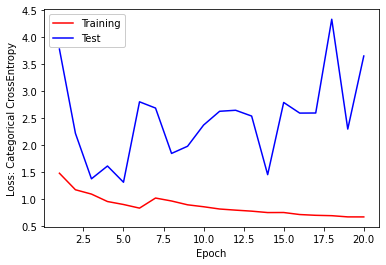

In [39]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history9.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history9.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

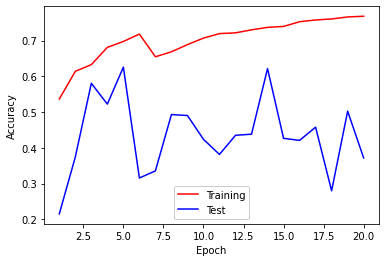

In [40]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history9.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history9.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Modelo 3

In [41]:
#Definicion del modelo
#Igual Dropout para todas las capas ocultas

i10 = Input((x_train.shape[1],))
d10 = Dense(512, activation='relu')(i10)
d10 = BatchNormalization()(d10)
d10 = Dropout(0.1)(d10)
d10 = Dense(256, activation='relu')(d10)
d10 = BatchNormalization()(d10)
d10 = Dropout(0.1)(d10)
d10 = Dense(128, activation='relu')(d10)
d10 = BatchNormalization()(d10)
d10 = Dropout(0.1)(d10)
d10 = Dense(25, activation='softmax')(d10)
model10 = Model(i10, d10)
model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model10.summary()
history10 = model10.fit(x_train, yc_train, epochs=20, verbose=1, validation_data=(x_test, yc_test))

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0   

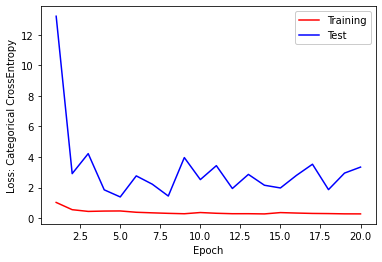

In [42]:
#Comportamiento de la funcion de costo para train y test

plt.plot(range(1, 21), history10.history['loss'], 'r-',label='Training')
plt.plot(range(1, 21), history10.history['val_loss'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Loss: Categorical CrossEntropy')
plt.show()

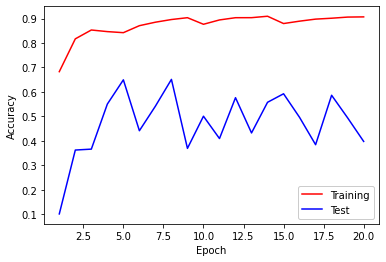

In [43]:
#Comportamiento de la metrica (accuracy) para train y test

plt.plot(range(1, 21), history10.history['accuracy'], 'r-',label='Training')
plt.plot(range(1, 21), history10.history['val_accuracy'], 'b-', label='Test')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Observaciones:



*   Por el uso de Dropout se observa un efecto de aplanado de las curvas de errores y accuracy para train
*   Nuevamente se observa un comportamiento muy oscilante para accuracy en test

